In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import hook_outputs
import os
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Model Architecture**

In [3]:
def conv_layer(ni, nf, k, stride, act = True, zero_bn = False):
  layers = [nn.Conv2d(ni, nf, k, stride = stride, padding = k//2, bias = False)]
  bn = nn.BatchNorm2d(nf)
  if zero_bn:
    bn.weight.data.zero_()
  layers.append(bn)
  if act:
    layers.append(nn.ReLU())
  return nn.Sequential(*layers)  

In [4]:
class MergeLayer(nn.Module):
  def __call__(self, x1, x2, dense = False):
    if dense:
      return torch.cat([x1, x2], dim = 1)
    else:
      return x1.add_(x2)

In [5]:
class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride, downsampler = None):
    super().__init__()
    self.downsampler = downsampler
    self.stride = stride  
    nh = nf//2
    self.conv1 = conv_layer(ni, nh, 1, stride = 1)
    self.conv2 = conv_layer(nh, nh, 3, stride = stride)
    self.conv3 = conv_layer(nh, nf, 1, stride = 1, act = False, zero_bn = True)

    self.merge_layer = MergeLayer()

    if self.downsampler is None:
      self.downsampler = nn.AvgPool2d(2, 2, padding = 1)
    # Downsampling Path 
    self.conv4 = conv_layer(ni, nf, 1, stride = 1, act = False)
    self.act_fn = nn.ReLU()

  def forward(self, x):
    residual = x
    out = self.conv3(self.conv2(self.conv1(x)))
    if self.stride > 1:
      residual = self.downsampler(residual)
    residual = self.conv4(residual)
    return self.act_fn(self.merge_layer(residual, out))

In [6]:
def flatten_conv(x, num_anchors_per_cell):
  bs, nf, grid, grid = x.shape
  return x.view(bs, -1, nf//num_anchors_per_cell)

In [7]:
class OutConv(nn.Module):
  def __init__(self, ni, k = 1, stride = 1, num_categories = None, num_anchorbxs = 9):
    super().__init__()
    self.num_anchorbxs = num_anchorbxs 
    self.classifier_head = nn.Conv2d(ni, int((num_categories)*num_anchorbxs), k, stride = 1, padding = k//2) 
    self.regressor_head = nn.Conv2d(ni, int(4*num_anchorbxs), k, stride = 1, padding = k//2)
  
  def forward(self, x):
    classification_results = self.classifier_head(x)
    bboxes = self.regressor_head(x)
    return [flatten_conv(classification_results, self.num_anchorbxs), 
            flatten_conv(bboxes, self.num_anchorbxs)]

In [8]:
def get_module_children(module):
  return list(module.children())

def all_children(model):
  children = []
  for m in model.children():
    if len(list(m.children())) != 0:
      children += all_children(m)
    else:
      children += [m]
  return children 

In [9]:
def get_specific_grid_size(model, image_size = [1, 3, 224, 224]):
  rand_img = torch.rand(*image_size)
  real_img = rand_img
  downsample_shapes = []
  model_layers = model
  for idx, l in enumerate(model_layers.children()):
    try:
      rand_img = l(rand_img)
      if (rand_img.shape[2] != real_img.shape[2]) and (rand_img.shape[2] not in downsample_shapes):
        downsample_shapes.append(rand_img.shape[2])
    except Exception: continue
  print('Available Grid Sizes', downsample_shapes)

In [10]:
def model_idx_for_gridsize(model, grid_sizes = [28, 14, 7]):
  rand_img = torch.rand(1, 3, 224, 224) 
  model_idx = []
  for idx, layer in enumerate(model.children()):
    rand_img = layer(rand_img)
    try:
      if rand_img.shape[2] in grid_sizes:
        model_idx.append((rand_img.shape[2], idx))
    except Exception: break
  return model_idx

In [11]:
from fastai.callbacks.hooks import hook_output
import pdb
class SSD_Model(nn.Module):

  def __init__(self, grids = [4, 2, 1], backbone_grids = [28, 14, 7], 
               backbone = models.xresnet34, pretrained = True,
               num_categories = None, anchors_per_cell = 9
               ):
    super().__init__()

    self.num_categories = num_categories 
    self.anchors_per_cell = anchors_per_cell  
    self.backbone = nn.Sequential(*list(backbone(pretrained).children())[:-2])
    self.backbone_grids = backbone_grids 
    self.grids =  grids
    self.hook_convs()    
    self.setup_out_convs()

    if torch.cuda.is_available(): self.device = torch.device('cuda')
    else: self.device = torch.device('cpu')

    self.setup_device() 

  def forward(self, x):

    classification_results = []
    bbox_results = []
    # pdb.set_trace()
    out = self.backbone(x)
    for resblock, outblock in zip(self.conv_blocks, self.out_blocks):
      out = resblock(out)
      clas_out, bbox_out = outblock(out)
      classification_results.append(clas_out); bbox_results.append(bbox_out)

    for idx, module_list in enumerate(self.backbone_convs):
      current_hook = self.outputs[idx].stored
      clas_out, bbox_out = module_list(current_hook)
      classification_results.append(clas_out); bbox_results.append(bbox_out)
    return torch.cat(classification_results, dim = 1), torch.cat(bbox_results, dim = 1)
  
  def register_hooks(self):
    self.outputs = []
    self.backbone_idxs = model_idx_for_gridsize(self.backbone)
    for grid_size, index in self.backbone_idxs:
      self.outputs.append(hook_output(self.backbone[index], detach = False))
  
  def module_list_for_hooks(self):
    self.register_hooks()
    self.backbone_convs = []
    for idx, hook in enumerate(self.outputs):
      self.backbone_convs.append(nn.Sequential())
  
  def hook_convs(self, num_id_convs = 1):
    self.module_list_for_hooks()
    dummy_out = self.backbone(self.dummy_batch)
    for idx, module_list in enumerate(self.backbone_convs):
      current_hook_out = self.outputs[idx].stored
      _, in_channels, grid, grid = current_hook_out.shape
      nf = 256
      for i in range(num_id_convs): 
        module_list.add_module(f'idconv{i}', ResBlock(in_channels, nf, stride = 1))
        if nf > 64: nf /= 2
      module_list.add_module(f'out_conv{i}', OutConv(int(nf*2), num_categories = self.num_categories,
                                                     num_anchorbxs = self.anchors_per_cell))

  @property
  def dummy_batch(self, input_shape = 224): return torch.rand((2, 3, input_shape, input_shape))

  @property 
  def backbone_final_channel(self):
    _, channel, grid, grid = self.backbone(self.dummy_batch).shape
    return channel 
  
  def setup_out_convs(self):
    self.conv_blocks = []; nf = 256; self.out_blocks = []
    for idx, grid_size in enumerate(self.grids):
      self.conv_blocks.append(ResBlock(self.backbone_final_channel if idx == 0 else nf, nf, stride = 2,
                                       downsampler = None if idx == 0 else nn.AvgPool2d(2, 2, ceil_mode= True)))
      self.out_blocks.append(OutConv(nf, num_categories = self.num_categories, num_anchorbxs = self.anchors_per_cell))
  
  def setup_device(self):
    self.backbone = self.backbone.to(self.device)
    self.conv_blocks = [blk.to(self.device) for blk in self.conv_blocks]
    self.out_blocks = [blk.to(self.device) for blk in self.out_blocks]
    self.backbone_convs = [blk.to(self.device) for blk in self.backbone_convs]

  def __repr__(self):
    super().__repr__()
    text = self.backbone.__repr__()
    for idx, grid_size in enumerate(self.backbone_grids):
      text += f'Grid Size: {grid_size} \n'
      text += str(self.backbone_convs[idx]) + '\n'

    for idx, (resblock, outblock) in enumerate(zip(self.conv_blocks, self.out_blocks)):
      text += f'Grid Size: {self.grids[idx]} \n'
      text += str(resblock) + '\n'
      text += str(outblock) + '\n'
    
    return text

# This is under development 
# Discriminative Learning Rates for each part of the model 
#   def setup_optimizer(self):
#     self.optim = OptimWrapper(torch.optim.Adam([
#       {'params': self.backbone.parameters(), 'lr': 1e-6},
#       {'params': nn.ModuleList(self.out_blocks).parameters(), 'lr': 1e-3},
#       {'params': nn.ModuleList(self.conv_blocks).parameters(), 'lr':1e-2},
#       {'params': nn.ModuleList(self.backbone_convs).parameters(), 'lr':1e-3}                                  
#     ]))

In [ ]:
path = untar_data(URLs.COCO_SAMPLE)
train_imgs, train_bboxes = get_annotations(path/'annotations/train_sample.json')
img2bbox = dict(zip(train_imgs, train_bboxes))

def get_y_func(x):
  try:
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes]
  except Exception as e:
   return [[[0.]*4], ['background']]
   
data = (ObjectItemList
        .from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y = True, size = 224)
        .databunch(bs = 32, collate_fn = bb_pad_collate)
        .normalize(imagenet_stats))

In [ ]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

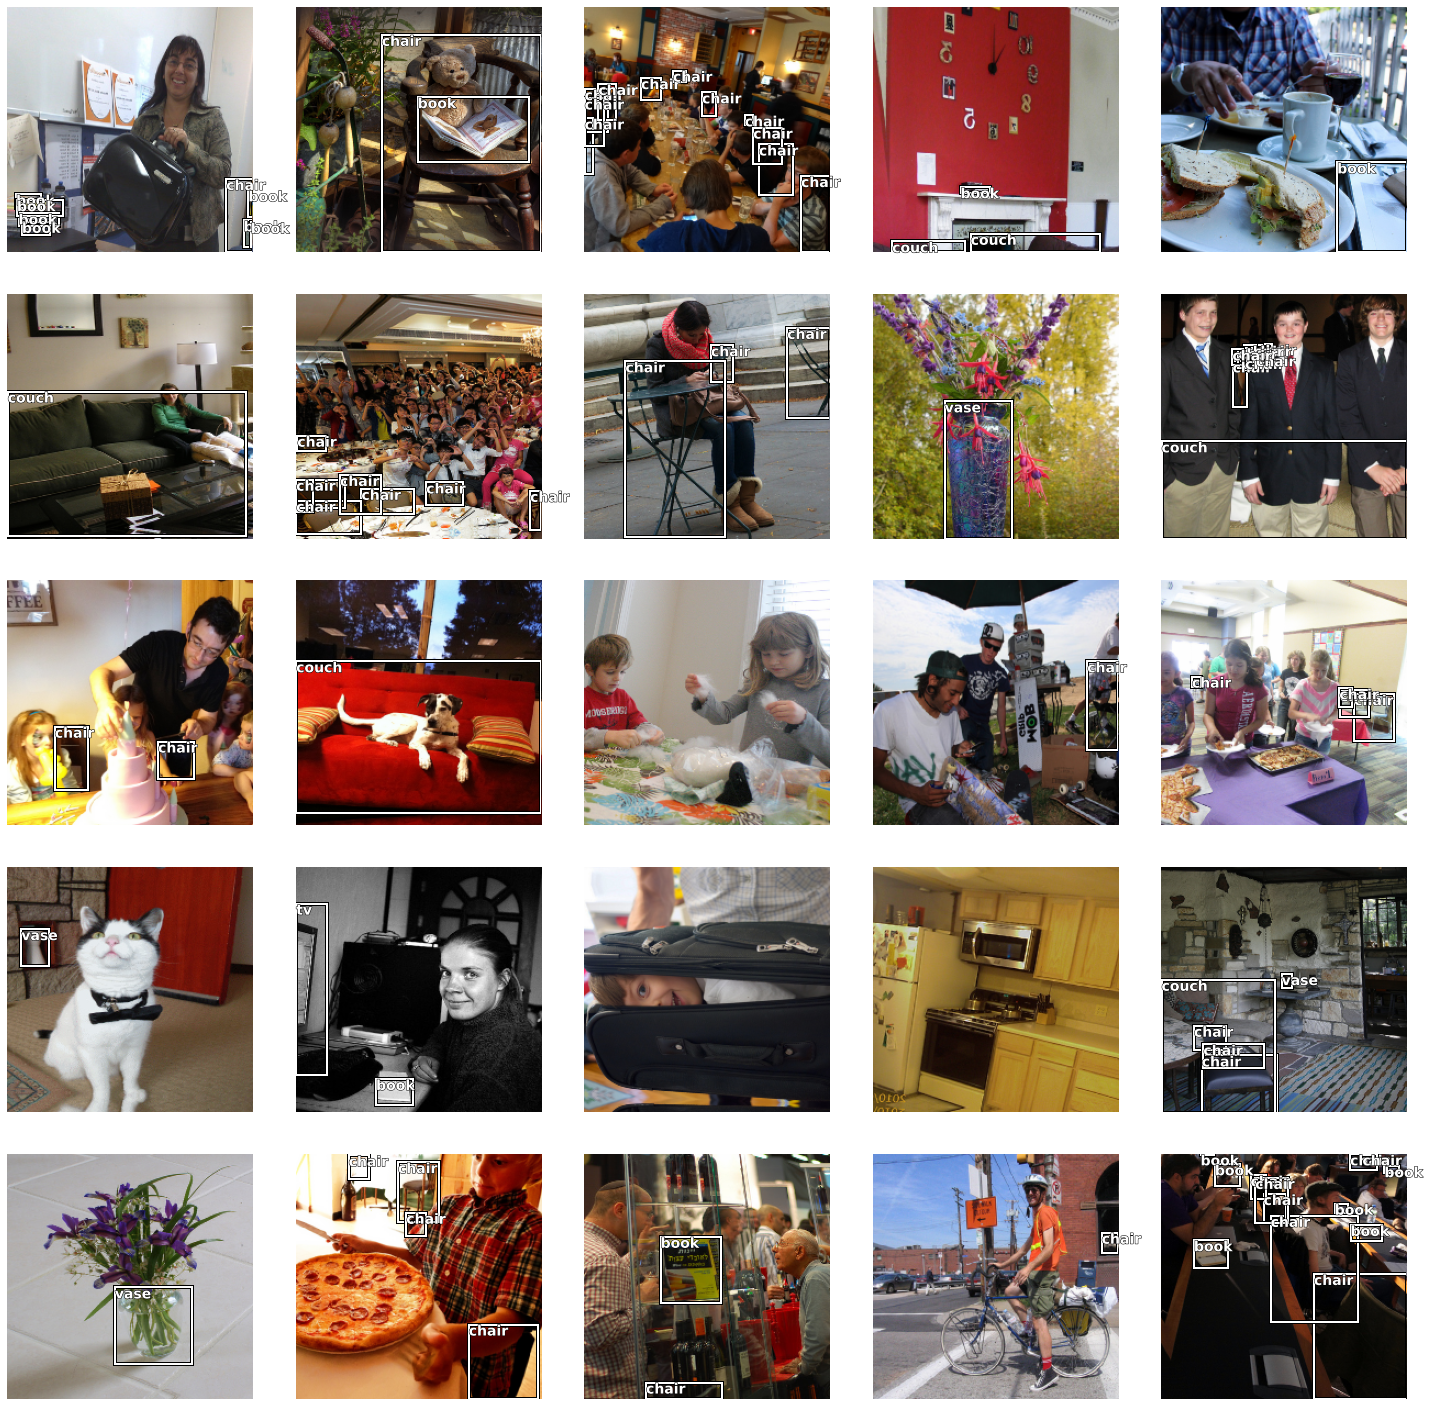

In [ ]:
data.show_batch()

In [ ]:
## Loss
def one_hot(labels, num_classes):
  return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
  
  def forward(self, pred, targ):
    # pdb.set_trace()
    target = one_hot(targ, self.num_classes)
    target = torch.Tensor(target[:, 1:].contiguous()).cuda()
    pred = pred[:, 1:]
    weight = self.get_weights(pred, target)
    return F.binary_cross_entropy_with_logits(pred, target, weight, size_average = False)/(self.num_classes - 1)
  
  def get_weights(self, pred, target): return None 

## **Learner**

In [ ]:
class SSD_Learner:

  def __init__(self, 
               data, 
               grids = [4, 2, 1], 
               backbone_grids = [28, 14, 7], 
               backbone = models.resnet34, pretrained = True, 
               ratios = [[1., 1.], [0.5, 1.], [1., 0.5]], zooms = [0.7, 1., 1.3], 
               ):
    self.ratios = ratios
    self.grids = grids 
    self.backbone_grids = backbone_grids 
    self.zooms = zooms  

    if torch.cuda.is_available():
      self.device = torch.device('cuda')
    else: self.device = torch.device('cpu')
    self.create_anchors()

    self.model = SSD_Model(self.grids, self.backbone_grids, backbone, pretrained, data.c, self.anchors_per_cell)
    self.model.setup_optimizer()
    self.classifier_loss = BCE_Loss(data.c) 

    self.learner = Learner(data, self.model)
    self.learner.loss_func = self.ssd_loss  
    
  @property
  def total_grids(self): return self.backbone_grids + self.grids 

  @property
  def anchors_per_cell(self):
    return len(self.anc_scales) 

  def create_anchors(self):
    self.anc_scales = [(anz*i, anz*j) for anz in self.zooms for i, j in self.ratios]
    self.anc_offsets = np.array([0.5/ag for ag in self.total_grids])
    self.anc_xs = np.concatenate([np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) 
                                  for anc_offset, anc_grid in zip(self.anc_offsets, self.total_grids)])
    self.anc_ys = np.concatenate([np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
                                  for anc_offset, anc_grid in zip(self.anc_offsets, self.total_grids)])
    self.anc_ctrs = np.repeat(np.stack([self.anc_xs, self.anc_ys], axis = 1), self.anchors_per_cell, axis = 0)
    self.anc_sizes = np.concatenate([np.array([[w/anc_grid, h/anc_grid] 
                                              for i in range(anc_grid**2) for w, h in self.anc_scales])
                                              for anc_grid in self.total_grids])
    self.anchors = torch.Tensor(np.concatenate([self.anc_ctrs, self.anc_sizes], axis = 1)).float().to(self.device)

    self.grid_sizes = torch.Tensor(np.concatenate([np.array([1/anc_grid for i in range(anc_grid**2) for w, h in self.anc_scales])
                                                    for anc_grid in self.total_grids])).unsqueeze(1).to(self.device)

    self.anchor_corners = self.hw_to_corners(self.anchors[:, :2], self.anchors[:, 2:])

  def get_y(self, bbox, classes):
    bbox = bbox.view(-1, 4)
    bbox_keep = ((bbox[:, 2] - bbox[:, 0]) > 0.).nonzero()[:, 0]
    return bbox[bbox_keep], classes[bbox_keep]
  
  def hw_to_corners(self, ctrs, hw):
    return torch.cat([ctrs - hw/2, ctrs + hw/2], dim = 1)
  
  def actn_to_bboxes(self, actn):
    actn_bb = torch.tanh(actn)
    actn_ctrs = (actn[:, :2]/2 * self.grid_sizes) + self.anchors[:, :2]
    actn_hw = (actn[:, 2:]/2 + 1) * self.anchors[:, 2:]
    return self.hw_to_corners(actn_ctrs, actn_hw)

  def intersect(self, box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

  def box_sz(self, b): 
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

  def jaccard(self, box_a, box_b):
    inter = self.intersect(box_a, box_b)
    union = self.box_sz(box_a).unsqueeze(1) + self.box_sz(box_b).unsqueeze(0) - inter
    return inter / union

  def normalize_bbox(self, bbox): 
    return (bbox+1.)/2.
  
  def match_ground_truth(self, overlaps):
    prior_overlaps, prior_idx = overlaps.max(1)
    gt_overlaps, gt_idx = overlaps.max(0)
    gt_overlaps[prior_idx] = 1.99 
    for i, o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlaps, gt_idx
  
  def ssd_1_loss(self, b_c, bb, bbox, classes):
    # pdb.set_trace()
    bbox, classes = self.get_y(bbox, classes)
    bbox = self.normalize_bbox(bbox)
    act_bxs = self.actn_to_bboxes(bb)
    overlaps = self.jaccard(bbox.data, self.anchor_corners.data)

    try:
      gt_overlaps, gt_idxs = self.match_ground_truth(overlaps)
    except Exception as e: return 0., 0. 
    gt_clas = classes[gt_idxs]
    pos = gt_overlaps > 0.4 
    pos_idx = torch.nonzero(pos)[:, 0]
    non_pos = [idx for idx, boolean in enumerate(pos) if not boolean]
    gt_clas[non_pos] = 0
    gt_bbox = bbox[gt_idxs]
    loc_loss = ((act_bxs[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    classification_loss = self.classifier_loss(b_c[pos_idx], gt_clas[pos_idx])

    return loc_loss, classification_loss 

  def ssd_loss(self, pred, bboxes, classes):
    localisation_loss, classification_loss = 0., 0.
    for actn_class, actn_bbox, orig_bbox, orig_class in zip(*pred, bboxes, classes):
      loc_loss, class_loss = self.ssd_1_loss(actn_class, actn_bbox, orig_bbox.to(self.device), orig_class.to(self.device))
      localisation_loss += loc_loss 
      classification_loss += class_loss
    loss = torch.tensor(localisation_loss + classification_loss, requires_grad=  True)
    return loss

  @property 
  def anchors_per_cell(self):return len(self.anc_scales) 

  @property
  def total_boxes(self): return self.anchors.shape[0]

  def visualise_anchors(self, grid_size):
    self.visualiser = Anchor_Visualizer(grid_size = grid_size)
    self.visualiser.plot()

  def visualise_boxes(self):
    radiobtn = widgets.RadioButtons(
        options = self.total_grids,
        description = 'Grid Size'
    )
    widgets.interact(self.visualise_anchors, grid_size = radiobtn)
       

In [ ]:
learn = SSD_Learner(data)

In [ ]:
learn.learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


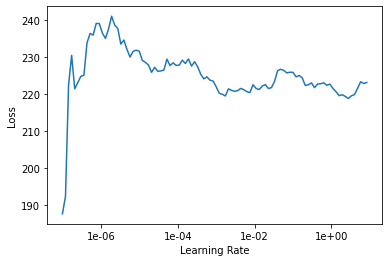

In [ ]:
learn.learner.recorder.plot(skip_start = 0, skip_end = 0)

In [ ]:
learn.learner.fit(10, lr = 1e-2)

epoch,train_loss,valid_loss,time


### **Anchors**

In [ ]:
#### This section is under development 

In [ ]:
import ipywidgets as widgets
import matplotlib.patches as pat
class Anchor_Visualizer:
  """
  widgets = the attributes for which widgets are created 
      -> default = ['anchor offset']
  """

  def __init__(self, 
               grid_size = 4, 
               zooms = [0.7, 1., 1.3], 
               ratios = [[1., 1.], [0.5, 1.], [1., 0.5]], 
                ):
    
    self.zooms = zooms 
    self.grid_size = grid_size
    self.ratios = ratios
    self.scale  
    self.setup_widgets()

  def setup_widgets(self):
    self.offset_widget = widgets.FloatSlider(min = 0.1, max = 1.5, step = 0.05, value = 0.5)
  
  def get_anchors(self, offset_widget):
    self.anc_scales = [(anz*i, anz*j) for anz in self.zooms for i, j in self.ratios]
    self.grid_offset = offset_widget/self.grid_size
    range_values = np.linspace(self.grid_offset, 1-self.grid_offset, self.grid_size)
    self.anc_xs = np.repeat(range_values, self.grid_size)
    self.anc_ys = np.tile(range_values, self.grid_size)
    self.anc_ctrs = np.repeat(np.stack([self.anc_xs, self.anc_ys], axis = 1), self.num_boxes_per_grid, axis = 0)
    self.anc_sz = np.array([[w/self.grid_size, h/self.grid_size] for i in range(self.grid_size**2) 
                                                          for w, h in self.anc_scales])
    anchors = np.concatenate([self.anc_ctrs, self.anc_sz], axis = 1)
    return anchors

  @property
  def num_boxes_per_grid(self): return len(self.anc_scales)

  @property
  def total_boxes(self): return self.anchors.shape[0]

  @property 
  def scale(self): return self.grid_size*100 

  @property 
  def blank_image(self): return np.full((self.scale, self.scale, 3), 255, np.uint8)/255.

  def tfm_coords(self, coords):
    x, y, width, height = coords
    x = x - width/2
    y = y - height/2 
    return np.array([x, y, width, height])

  def plot_anchors(self, offset_widget):
    fig, ax = plt.subplots(1, figsize = (15, 15))
    ax.clear()
    anchors = self.get_anchors(offset_widget)
    ax.imshow(self.blank_image)

    for idx, coords in enumerate(anchors):
      x_ctr, y_ctr = coords[:2]*self.scale
      ctr_patch = pat.Circle((x_ctr, y_ctr), 0.009*self.scale)
      x, y, width, height = self.tfm_coords(coords)*self.scale
      rect_patch = pat.Rectangle((x, y), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
      ax.add_patch(ctr_patch)
      ax.add_patch(rect_patch)

  def plot(self):
     return widgets.interact(self.plot_anchors, offset_widget = self.offset_widget)

In [ ]:
vis = Anchor_Visualizer()
vis.plot()

interactive(children=(FloatSlider(value=0.5, description='offset_widget', max=1.5, min=0.1, step=0.05), Output…

In [ ]:
anc_ctrs[:9]

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [ ]:
import matplotlib.patches as pat 
def distance(x1, y1, x2, y2):
  return math.sqrt((x1-x2)**2 + (y1-y2)**2)
def plot_grid_ctrs(image, scale):
  fig, ax = plt.subplots(1)
  dist = np.array([anc_ctrs[0], anc_ctrs[0+len(anc_scales)]])
  dist = distance(*dist.ravel())
  ax.imshow(image)
  for idx, coords in enumerate(anchors):
    x_ctr, y_ctr = coords[:2]*scale
    grid_ctr = pat.Circle((x_ctr, y_ctr), 0.009*scale, linewidth = 1)
    ax.add_patch(grid_ctr)
  print(dist)
  plt.show()

In [ ]:
def rectify_coord(coord):
  x, y, width, height = coord 
  x = x - width/2
  y = y - height/2
  return np.array([x, y, width, height])

In [ ]:
def plot_rectangles(image, scale, num_rectangles, indx = None):
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  for idx, rect_coords in enumerate(anchors):
    if idx == num_rectangles: break
    x_ctr, y_ctr = rect_coords[:2]*scale
    x, y, width, height = rectify_coord(rect_coords)*scale
    center_patch = pat.Circle((x_ctr, y_ctr),0.009*scale, linewidth = 1)
    if indx is not None:
      if idx ==indx:
        patch = pat.Rectangle((x, y), width, height, linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(patch)
    else:
      patch = pat.Rectangle((x, y), width, height, linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(patch)
    ax.add_patch(center_patch)
  plt.show()

0.20833333333333337


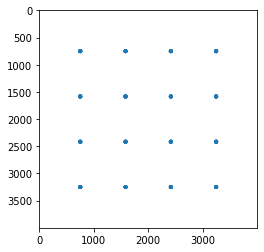

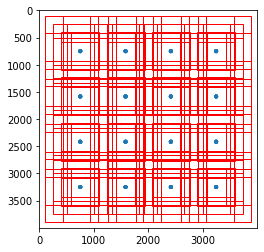

In [ ]:
import cv2 
from google.colab.patches  import cv2_imshow

image = np.full((4000, 4000, 3), 255, np.uint8)/255
plot_grid_ctrs(image, 4000)
plot_rectangles(image, 4000, 144)